<a href="https://colab.research.google.com/github/jackodonoghue/A-DS/blob/master/FYP_IoT_DoS_IDS_Run_from_Local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import files

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving wireshark_benign_1884.csv to wireshark_benign_1884.csv
Saving wireshark_benign_1884_2.csv to wireshark_benign_1884_2.csv
Saving wireshark_benign_9022.csv to wireshark_benign_9022.csv
Saving wireshark_benign_9022_bbbb.csv to wireshark_benign_9022_bbbb.csv
Saving wireshark_udpflood_10231_aaaa.csv to wireshark_udpflood_10231_aaaa.csv
Saving wireshark_udpflood_60001_aaaa.csv to wireshark_udpflood_60001_aaaa.csv
Saving wireshark_udpflood_60001_bbbb.csv to wireshark_udpflood_60001_bbbb.csv


In [ ]:
#imports
import pandas as pd

In [ ]:
#read in data
#Benign
wireshark_benign_1884=pd.read_csv(open('/content/wireshark_benign_1884.csv'))
wireshark_benign_1884_2=pd.read_csv(open('/content/wireshark_benign_1884_2.csv'))
wireshark_benign_9022=pd.read_csv(open('/content/wireshark_benign_9022.csv'))
wireshark_benign_9022_bbbb=pd.read_csv(open('/content/wireshark_benign_9022_bbbb.csv'))

#DoS
wireshark_udpflood_10231=pd.read_csv(open('/content/wireshark_udpflood_10231_aaaa.csv'))
wireshark_udpflood_60001_bbbb=pd.read_csv(open('/content/wireshark_udpflood_60001_bbbb.csv'))

In [ ]:
wireshark_benign_1884.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,fe80::504e:9624:3ae7:90c3,ff02::2,ICMPv6,48,Router Solicitation
1,2,15.611043,fe80::504e:9624:3ae7:90c3,ff02::2,ICMPv6,48,Router Solicitation
2,3,18.363585,aaaa::c30c:0:0:2,aaaa::1,UDP,70,1884 > 1884 Len=22
3,4,18.364787,aaaa::1,aaaa::c30c:0:0:2,UDP,51,1884 > 1884 Len=3
4,5,18.412857,aaaa::c30c:0:0:2,aaaa::1,UDP,62,1884 > 1884 Len=14


#Preprocessing

In [ ]:
#imports
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
#functions
def clean(df_to_clean, packet_type):
  #remove rows from unnessesary row
  df=df_to_clean[df_to_clean.Protocol=='UDP']
  df['Target'] = pd.Series(packet_type, index=df.index)
  #change time to time since last packet
  df['Time']=time_to_duration(df['Time'])
  #split Info column
  df=df.join(df.Info.str.split(expand=True))
  #drop Info column and column with '>'
  df=df.drop(['No.', 'Info', 1], axis=1)
  #remove 'Len=' from length columns
  df[3] = df[3].str.extract('(\d+)', expand=False)
  df.rename(columns={'Time': 'Duration', 'Source':'SourceIP', 'Destination': 'DestinationIP', 0: 'SourcePort', 2: 'DestinationPort', 3:'InfoLength'}, inplace=True)
 # df=categorical_to_numeric(df)
  return df

#change duration to time
def time_to_duration(time):
  time=time.tolist()
  duration=[]
  for i in range(len(time)):
    duration.append(time[i]-time[i-1])
  duration[0]=0.0
  return duration

def create_data_and_target(df):
  benign= df.loc[df['Target'] == 0]
  malicious= df.loc[df['Target'] == 1]  

  benign_data, benign_target=create_target(benign)
  malicious_data, malicious_target=create_target(malicious)

  benign_data=categorical_to_numeric(benign)
  malicious_data=categorical_to_numeric(malicious)
  
  return benign_data.to_numpy(), benign_target.to_numpy(), malicious_data.to_numpy(), malicious_target.to_numpy() 
  #return all lists as benign data/target and udp flood data/target
  
#used to create data values for data
def create_target(data):
  target=data['Target']
  data=data.drop('Target', axis=1, inplace=True)
  return data, target

#convert non numeric values for use with SVC
def categorical_to_numeric(df):
  df['SourceIP'] = LabelEncoder().fit_transform(df.SourceIP.values)
  df['DestinationIP'] = LabelEncoder().fit_transform(df.DestinationIP.values)
  df['Protocol'] = LabelEncoder().fit_transform(df.Protocol.values)
  return df

In [ ]:
wireshark_benign_1884.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,fe80::504e:9624:3ae7:90c3,ff02::2,ICMPv6,48,Router Solicitation
1,2,15.611043,fe80::504e:9624:3ae7:90c3,ff02::2,ICMPv6,48,Router Solicitation
2,3,18.363585,aaaa::c30c:0:0:2,aaaa::1,UDP,70,1884 > 1884 Len=22
3,4,18.364787,aaaa::1,aaaa::c30c:0:0:2,UDP,51,1884 > 1884 Len=3
4,5,18.412857,aaaa::c30c:0:0:2,aaaa::1,UDP,62,1884 > 1884 Len=14
5,6,18.412940,aaaa::1,aaaa::c30c:0:0:2,UDP,55,1884 > 1884 Len=7
6,7,18.459126,aaaa::c30c:0:0:2,aaaa::1,UDP,62,1884 > 1884 Len=14
7,8,18.459217,aaaa::1,aaaa::c30c:0:0:2,UDP,55,1884 > 1884 Len=7
8,9,18.462152,aaaa::c30c:0:0:4,aaaa::1,UDP,70,1884 > 1884 Len=22
9,10,18.462232,aaaa::1,aaaa::c30c:0:0:4,UDP,51,1884 > 1884 Len=3


In [ ]:
wireshark_udpflood_60001_bbbb.head(10)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,fe80::79fa:fdfd:46ef:d156,ff02::2,ICMPv6,48,Router Solicitation
1,2,16.127682,fe80::79fa:fdfd:46ef:d156,ff02::2,ICMPv6,48,Router Solicitation
2,3,44.060629,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,56734 > 60001 Len=1024
3,4,44.060735,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,38472 > 60001 Len=1024
4,5,44.060790,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,50641 > 60001 Len=1024
5,6,44.060873,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,34065 > 60001 Len=1024
6,7,44.060927,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,34657 > 60001 Len=1024
7,8,44.060976,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,41508 > 60001 Len=1024
8,9,44.061023,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,33359 > 60001 Len=1024
9,10,44.061069,bbbb::1,bbbb::c30c:0:0:1,UDP,1072,40293 > 60001 Len=1024


In [ ]:
#clean data
#benign
clean_benign_1884=clean(wireshark_benign_1884, 0)
clean_benign_1884_2=clean(wireshark_benign_1884_2, 0)
clean_benign_9022=clean(wireshark_benign_9022, 0)
clean_benign_9022_bbbb=clean(wireshark_benign_9022_bbbb, 0)

#DoS
clean_udpflood_10231=clean(wireshark_udpflood_10231, 1)
clean_udpflood_60001_bbbb=clean(wireshark_udpflood_60001_bbbb, 1)

In [ ]:
clean_benign_9022_bbbb.DestinationIP.unique()

array(['bbbb::1', 'bbbb::c30c:0:0:2', 'bbbb::c30c:0:0:4',
       'bbbb::c30c:0:0:3'], dtype=object)

In [ ]:
clean_udpflood_10231.DestinationIP.unique()

array(['aaaa::c30c:0:0:1'], dtype=object)

In [ ]:
clean_udpflood_10231.head()

,Duration,SourceIP,DestinationIP,Protocol,Length,Target,SourcePort,DestinationPort,InfoLength
1,0.000000,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,60115,10231,1024
2,0.000106,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,37768,10231,1024
3,0.000055,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,49521,10231,1024
4,0.000047,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,57083,10231,1024
5,0.000046,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,37949,10231,1024


In [ ]:
clean_udpflood_10231[['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort']].head(10)

,SourceIP,DestinationIP,SourcePort,DestinationPort
1,aaaa::1,aaaa::c30c:0:0:1,60115,10231
2,aaaa::1,aaaa::c30c:0:0:1,37768,10231
3,aaaa::1,aaaa::c30c:0:0:1,49521,10231
4,aaaa::1,aaaa::c30c:0:0:1,57083,10231
5,aaaa::1,aaaa::c30c:0:0:1,37949,10231
6,aaaa::1,aaaa::c30c:0:0:1,50697,10231
7,aaaa::1,aaaa::c30c:0:0:1,42588,10231
8,aaaa::1,aaaa::c30c:0:0:1,40139,10231
9,aaaa::1,aaaa::c30c:0:0:1,36741,10231
10,aaaa::1,aaaa::c30c:0:0:1,37913,10231


In [ ]:
clean_udpflood_10231.head()

,Duration,SourceIP,DestinationIP,Protocol,Length,Target,SourcePort,DestinationPort,InfoLength
1,0.000000,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,60115,10231,1024
2,0.000106,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,37768,10231,1024
3,0.000055,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,49521,10231,1024
4,0.000047,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,57083,10231,1024
5,0.000046,aaaa::1,aaaa::c30c:0:0:1,UDP,1072,1,37949,10231,1024


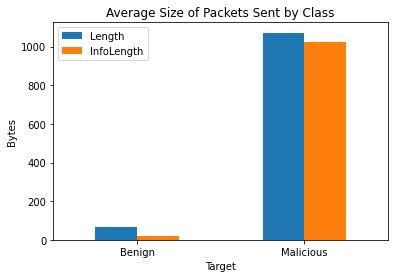

In [ ]:
clean_b=clean(wireshark_benign_1884, 0)

clean_m=clean(wireshark_udpflood_10231, 1)

df=clean_b[['Length', 'InfoLength', 'Target']].append(clean_m[['Length', 'InfoLength', 'Target']])
df.loc[(df.Target == 0),'Target']='Benign'
df.loc[(df.Target == 1),'Target']='Malicious'
df['InfoLength']=df['InfoLength'].astype(str).astype(int)

to_plot=df.groupby('Target').mean()
to_plot.plot(kind='bar', title='Average Size of Packets Sent by Class', ylabel='Bytes', rot=0)

In [ ]:
clean_benign_1884.DestinationIP.values

array(['aaaa::1', 'aaaa::c30c:0:0:2', 'aaaa::1', ..., 'aaaa::1',
       'aaaa::1', 'aaaa::1'], dtype=object)

In [ ]:
clean_benign_1884.SourceIP.values

array(['aaaa::c30c:0:0:2', 'aaaa::1', 'aaaa::c30c:0:0:2', ...,
       'aaaa::c30c:0:0:3', 'aaaa::c30c:0:0:2', 'aaaa::c30c:0:0:4'],
      dtype=object)

In [ ]:
clean_benign_1884.dtypes

Duration           float64
SourceIP            object
DestinationIP       object
Protocol            object
Length               int64
Target               int64
SourcePort          object
DestinationPort     object
InfoLength          object
dtype: object

In [ ]:
type(clean_benign_1884['Length'])

pandas.core.series.Series

In [ ]:
clean_benign_1884.head()

,Duration,SourceIP,DestinationIP,Protocol,Length,Target,SourcePort,DestinationPort,InfoLength
2,0.000000,aaaa::c30c:0:0:2,aaaa::1,UDP,70,0,1884,1884,22
3,0.001202,aaaa::1,aaaa::c30c:0:0:2,UDP,51,0,1884,1884,3
4,0.048071,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14
5,0.000083,aaaa::1,aaaa::c30c:0:0:2,UDP,55,0,1884,1884,7
6,0.046185,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14


In [ ]:
clean_benign_1884.head()

,Duration,SourceIP,DestinationIP,Protocol,Length,Target,SourcePort,DestinationPort,InfoLength
2,0.000000,aaaa::c30c:0:0:2,aaaa::1,UDP,70,0,1884,1884,22
3,0.001202,aaaa::1,aaaa::c30c:0:0:2,UDP,51,0,1884,1884,3
4,0.048071,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14
5,0.000083,aaaa::1,aaaa::c30c:0:0:2,UDP,55,0,1884,1884,7
6,0.046185,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14


In [ ]:
dataset_as_dataframe=pd.concat([clean_benign_1884, clean_benign_1884_2, clean_benign_9022, clean_benign_9022_bbbb, clean_udpflood_10231.sample(frac=.25), clean_udpflood_60001_bbbb.sample(frac=.25)])

In [ ]:
dataset_as_dataframe.shape

(262737, 9)

#Preprocessing


In [ ]:
#imports 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
clean_benign_1884.loc[clean_benign_1884['Target'] == 0]

,Duration,SourceIP,DestinationIP,Protocol,Length,Target,SourcePort,DestinationPort,InfoLength
2,0.000000,aaaa::c30c:0:0:2,aaaa::1,UDP,70,0,1884,1884,22
3,0.001202,aaaa::1,aaaa::c30c:0:0:2,UDP,51,0,1884,1884,3
4,0.048071,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14
5,0.000083,aaaa::1,aaaa::c30c:0:0:2,UDP,55,0,1884,1884,7
6,0.046185,aaaa::c30c:0:0:2,aaaa::1,UDP,62,0,1884,1884,14
...,...,...,...,...,...,...,...,...,...
45103,0.357342,aaaa::c30c:0:0:2,aaaa::1,UDP,70,0,1884,1884,22
45104,0.106963,aaaa::c30c:0:0:4,aaaa::1,UDP,70,0,1884,1884,22
45105,0.548673,aaaa::c30c:0:0:3,aaaa::1,UDP,70,0,1884,1884,22
45106,0.338235,aaaa::c30c:0:0:2,aaaa::1,UDP,70,0,1884,1884,22


In [ ]:
benign_data, benign_target, udp_flood_data, udp_flood_target=create_data_and_target(dataset_as_dataframe)

In [ ]:
benign_data

array([[0.0, 1, 0, ..., '1884', '1884', '22'],
       [0.0012019999999992592, 0, 1, ..., '1884', '1884', '3'],
       [0.04807067699999834, 1, 0, ..., '1884', '1884', '14'],
       ...,
       [0.5379910339997878, 6, 4, ..., '9022', '9022', '22'],
       [0.3393703760002609, 5, 4, ..., '9022', '9022', '22'],
       [0.1159420260000843, 7, 4, ..., '9022', '9022', '22']],
      dtype=object)

In [ ]:
target_names=np.array(['benign', 'malicious'])
target_names

array(['benign', 'malicious'], dtype='<U9')

In [ ]:
feature_names=np.array(clean_benign_1884.columns.values.tolist())
feature_names

array(['Duration', 'SourceIP', 'DestinationIP', 'Protocol', 'Length',
       'Target', 'SourcePort', 'DestinationPort', 'InfoLength'],
      dtype='<U15')

In [ ]:
data=[]
data.extend(benign_data.tolist())
data.extend(udp_flood_data.tolist())
data=np.array(data)

In [ ]:
data.shape

(262737, 8)

In [ ]:
target=[]
target.extend(benign_target.tolist())
target.extend(udp_flood_target.tolist())
target=np.array(target)

In [ ]:
target.shape

(262737,)

In [ ]:
shuffled_data, shuffled_target=shuffle(data, target, random_state=1)

In [ ]:
dataset={
    'data': shuffled_data,
    'feature_names': feature_names,
    'target': shuffled_target,
    'target_names': target_names,
}

In [ ]:
dataset

{'data': array([['0.11406342000009317', '3', '0', ..., '9022', '9022', '22'],
        ['7.354699999950753e-05', '0', '0', ..., '49667', '10231', '1024'],
        ['0.00012250500000732245', '1', '1', ..., '40472', '60001',
         '1024'],
        ...,
        ['0.00012922099999990166', '0', '0', ..., '34506', '10231',
         '1024'],
        ['5.615499958366854e-05', '0', '3', ..., '9022', '9022', '2'],
        ['0.0001315749999974969', '0', '0', ..., '41798', '10231', '1024']],
       dtype='<U32'),
 'feature_names': array(['Duration', 'SourceIP', 'DestinationIP', 'Protocol', 'Length',
        'Target', 'SourcePort', 'DestinationPort', 'InfoLength'],
       dtype='<U15'),
 'target': array([0, 1, 1, ..., 1, 0, 1]),
 'target_names': array(['benign', 'malicious'], dtype='<U9')}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['data'], dataset['target'], test_size=0.3,random_state=109)

#Create SVM

In [ ]:
#imports
from sklearn import svm

In [ ]:
from sklearn import metrics

In [ ]:
len(dataset['data'])

262737

In [ ]:
dataset['target'][:6]

array([0, 1, 1, 0, 1, 0])

In [ ]:
X_test.shape

(78822, 8)

In [ ]:
y_test.shape

(78822,)

In [ ]:
X_train.shape

(183915, 8)

In [ ]:
y_train.shape

(183915,)

In [ ]:
#create classifier
classifier=svm.SVC(kernel='linear')

#use training sets to train model
classified=classifier.fit(X_train, y_train)

#predict
predictions=classifier.predict(X_test)

In [ ]:
metrics.classification_report(y_test, predictions, target_names=['Benign', 'Malicious'])

'              precision    recall  f1-score   support\n\n      Benign       1.00      1.00      1.00     33435\n   Malicious       1.00      1.00      1.00     45387\n\n    accuracy                           1.00     78822\n   macro avg       1.00      1.00      1.00     78822\nweighted avg       1.00      1.00      1.00     78822\n'

In [ ]:
print(metrics.classification_report(y_test, predictions, target_names=['Benign', 'Malicious']))
print("Accuracy:", metrics.accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     33435
   Malicious       1.00      1.00      1.00     45387

    accuracy                           1.00     78822
   macro avg       1.00      1.00      1.00     78822
weighted avg       1.00      1.00      1.00     78822

Accuracy: 1.0


In [ ]:
benign_conf, malicious_conf=metrics.confusion_matrix(y_test, predictions)

print("\t   {}    {}\n".format("Benign", "Malicious"))
print("   Benign   {}            {}".format(benign_conf[0], benign_conf[1]))
print("Malicious       {}        {}".format(malicious_conf[0], malicious_conf[1]))

	   Benign    Malicious

   Benign   33435            0
Malicious       0        45387


In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, predictions))

#Testing 

In [ ]:
#convert 
def categorical_to_numeric(df):
  df['Protocol'] = LabelEncoder().fit_transform(df.Protocol.values)
  tmp=pd.DataFrame(columns=['SourceIP', 'DestinationIP'])
  tmp['SourceIP']=df['SourceIP']
  tmp['DestinationIP']=df['DestinationIP']
  LabelEncoder().fit(tmp.stack().unique())
  df['SourceIP'] = LabelEncoder().fit_transform(tmp.SourceIP.values)
  df['DestinationIP'] = LabelEncoder().fit_transform(tmp.DestinationIP.values)
  return df

In [ ]:
x=categorical_to_numeric(clean_udpflood_10231)

In [ ]:
x.

In [ ]:
f=pd.read_csv(open('/content/drive/My Drive/fyp_data/wireshark_benign_1884.csv'))

In [ ]:
df=pd.DataFrame(columns=['SourceIP', 'DestinationIP', 'Protocol'])


In [ ]:
mal=pd.DataFrame(columns=['SourceIP', 'DestinationIP', 'Protocol'])

In [ ]:
mal['SourceIP']=clean_udpflood_10231.SourceIP.values
mal['DestinationIP']=clean_udpflood_10231.DestinationIP.values
mal['Protocol']=clean_udpflood_10231.Protocol.values
categorical_to_numeric(mal)

In [ ]:
mal.SourceIP.unique()

In [ ]:
df['SourceIP']=clean_benign_1884.SourceIP.values
df['DestinationIP']=clean_benign_1884.DestinationIP.values
df['Protocol']=clean_benign_1884.Protocol.values
categorical_to_numeric(df)

In [ ]:
list_of_dataframes=[clean_benign_1884, clean_benign_1884_2]
dfs_to_one_list=[]
for l in list_of_dataframes:
  a = l
  a_to_list=[]
  a=a.to_numpy()
  a_to_list=a.tolist()
  dfs_to_one_list+=a_to_list

numpy_data=np.array(dfs_to_one_list)

In [ ]:
wireshark_udpflood_60001_bbbb[wireshark_udpflood_60001_bbbb.Protocol=='UDP']

In [ ]:
clean_benign_1884.shape

In [ ]:
numpy_data.shape

In [ ]:
a

In [ ]:
print(find_shape([clean_udpflood_10231]))
print(clean_udpflood_10231.shape)

In [ ]:
clean_udpflood_10231.shape

In [ ]:
df.head()

In [ ]:
df['Time'][1]

In [ ]:
t=[1,2,3,4,5,6,7,8,9]
l=[]
print(t)

for i in range(len(t)):
 l.append(t[i]-t[i-1])
print("l", l)
time=[1,2,3, 4,5,6,7,8,9]


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

In [ ]:
df=df.join(df.Info.str.split(expand=True))

In [ ]:
df.head()

In [ ]:
df=pd.DataFrame(df.Info.str.split(expand=True))

In [ ]:
df.head()

In [ ]:
clean_b=clean(wireshark_benign_1884, 0)

clean_m=clean(wireshark_udpflood_10231, 1)

In [ ]:
clean_b[['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort']].head(10)

In [ ]:
clean_m[['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort']].head(10)

In [ ]:
clean_b.columns

In [ ]:
df=clean_b[['Length', 'InfoLength', 'Target']].append(clean_m[['Length', 'InfoLength', 'Target']])
df.loc[(df.Target == 0),'Target']='Benign'
df.loc[(df.Target == 1),'Target']='Malicious'
df['InfoLength']=df['InfoLength'].astype(str).astype(int)

In [ ]:
df

,Length,InfoLength,Target
2,70,22,Benign
3,51,3,Benign
4,62,14,Benign
5,55,7,Benign
6,62,14,Benign
...,...,...,...
195571,1072,1024,Malicious
195572,1072,1024,Malicious
195573,1072,1024,Malicious
195574,1072,1024,Malicious


In [ ]:
clean_m[['Length', 'InfoLength']]